In [365]:
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 

from utils.load_datasets import load_dataset
from models import vgg
from models.cvae import CVAE
from models.vgg_vmmix import BiternionVGGMixture

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset_name = "CAVIAR-o" #"IDIAP" #"CAVIAR-o"
dataset_path = 'data/CAVIAR-o.pkl.gz' #'data//IDIAP.pkl' #'data/CAVIAR-o.pkl.gz' #
net_output = 'pan'
model_type = 'cvae'

In [3]:
(xtr, ytr_bit, ytr_deg), (xval, yval_bit, yval_deg), (xte, yte_bit, yte_deg) = load_dataset(dataset_name,
                                                                                            dataset_path,
                                                                                            net_output)

image_height, image_width, n_channels = xtr.shape[1], xtr.shape[2], xtr.shape[3]

In [548]:
if dataset_name=='CAVIAR-o':
    pretrained_path = 'pretrained_models/CAVIAR-o'

vggbit_cosine_config_path = os.path.join(pretrained_path, 'cosine/model.best.params.yml')
vggbit_cosine_weights_path = os.path.join(pretrained_path, 'cosine/model.best.weights.hdf5')
vggbit_likelihood_config_path = os.path.join(pretrained_path, 'likelihood/model.best.params.yml')
vggbit_likelihood_weights_path =  os.path.join(pretrained_path, 'likelihood/model.best.weights.hdf5')
vmmix_config_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.params.yml')
vmmix_weights_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.weights.hdf5')
cvae_config_path =  os.path.join(pretrained_path, 'cvae/model.trial_0.params.yml')
cvae_weights_path =  os.path.join(pretrained_path, 'cvae/model.trial_0.best.weights.hdf5')

In [270]:
def load_config(net_config_path):
    with open(net_config_path, 'r') as f:
        net_config = yaml.load(f)
    return net_config

vggbit_cosine_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=False,
                                loss_type='cosine',
                                **load_config(vggbit_cosine_config_path))
vggbit_cosine_model.load_weights(vggbit_cosine_weights_path)
_ = vggbit_cosine_model.finetune_kappa(xval, yval_bit, max_kappa=1000)

vggbit_likelihood_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=True,
                                loss_type='vm_likelihood',
                                **load_config(vggbit_likelihood_config_path))
vggbit_likelihood_model.load_weights(vggbit_likelihood_weights_path)

vmmix_model = BiternionVGGMixture(image_height=image_height,
                            image_width=image_width,
                            n_channels=3,
                            **load_config(vmmix_config_path))

vmmix_model.load_weights(vmmix_weights_path)
    


using cosine loss..
using likelihood loss..


In [654]:
load_config(vmmix_config_path)

{'batch_size': 8,
 'beta1': 0.90000000000000002,
 'beta2': 0.999,
 'ckpt_path': 'logs/CAVIAR-o/vm_mixture/vm_mixture_74bd0f95b6a5a4a8c2a2/1/model.trial_1.best.weights.hdf5',
 'conv_dropout': 0.20000000000000001,
 'cvae_fc_layer_size': 512,
 'epsilons': 1e-08,
 'fc_dropout': 0.5,
 'hyp_yaml_path': 'logs/CAVIAR-o/vm_mixture/vm_mixture_74bd0f95b6a5a4a8c2a2/1/model.trial_1.params.yml',
 'learning_rate': 0.0001,
 'n_components': 20,
 'vgg_fc_layer_size': 512}

In [677]:
from models.cvae import CVAE

cvae_model = CVAE(image_height=image_height,
                 image_width=image_width,
                 n_channels=n_channels,
                 **load_config(cvae_config_path))

cvae_model.load_weights(cvae_weights_path)

In [675]:
def eval_all_models(x, y_deg, data_part, n_samples=50):
    
    results = {}
    
    print("*****EVALUATING ON %s*****"%data_part)
    print("evaluating VGGBit (cosine loss)..")
    results['cosine'] = vggbit_cosine_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VGGBit (likelihood loss)..")
    results['likelihood'] = vggbit_likelihood_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VM-Mixture..")
    results['mixture'] = vmmix_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating CVAE..")
    results['cvae'] = cvae_model.evaluate(x, y_deg, data_part, return_per_image=True, n_samples=n_samples)
    
    return results

In [652]:
results_train = eval_all_models(xtr, ytr_deg, 'train')

*****EVALUATING ON train*****
evaluating VGGBit (cosine loss)..
MAAD error (train) : 3.196380 pm 0.031878SEM
log-likelihood (train) : 0.671936 pm 0.003236SEM
evaluating VGGBit (likelihood loss)..
MAAD error (train) : 2.626655 pm 0.037635SEM
log-likelihood (train) : 1.372437 pm 0.007118SEM
evaluating VM-Mixture..
MAAD error (train) : 0.660461 pm 0.016398SEM
log-likelihood (train) : 2.962003 pm 0.008497SEM


In [676]:
#results_val = eval_all_models(xval, yval_deg, 'validation')
results_test = eval_all_models(xte, yte_deg, 'test')

*****EVALUATING ON test*****
evaluating VGGBit (cosine loss)..
MAAD error (test) : 6.025821 pm 0.133064SEM
log-likelihood (test) : 0.241810 pm 0.034558SEM
evaluating VGGBit (likelihood loss)..
MAAD error (test) : 5.537397 pm 0.148111SEM
log-likelihood (test) : 0.555294 pm 0.070003SEM
evaluating VM-Mixture..
MAAD error (test) : 4.572951 pm 0.197118SEM
log-likelihood (test) : 1.857363 pm 0.041178SEM
evaluating CVAE..
MAAD error (test) : 6.397695 pm 0.183265SEM
ELBO (test) : 0.813280 pm 0.086576SEM
Approx Log-Likelihood, importance sampling (test) : 0.941751 pm 0.049947SEM
KL-div (test) : 0.109176 pm0.004948SEM


In [690]:
starting_frame = 200
n_frames = 20
frames = np.arange(starting_frame, starting_frame+n_frames)
n_samples = 100
xvals =  np.arange(0, 2*np.pi, 0.01)

results = eval_all_models(xte[frames], yte_deg[frames], 'test', n_samples=n_samples)

pdfs_dict = {}

vggcosine_acc_pdf = vggbit_cosine_model.pdf(xte[frames], xvals)

vgglikelihood_acc_pdf = vggbit_likelihood_model.pdf(xte[frames], xvals)

vmmix_pdfs, vmmix_acc_pdf = vmmix_model.pdf(xte[frames], xvals)

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[frames], xvals, n_samples=n_samples)

*****EVALUATING ON test*****
evaluating VGGBit (cosine loss)..
MAAD error (test) : 7.108523 pm 1.802370SEM
log-likelihood (test) : 0.275550 pm 0.215842SEM
evaluating VGGBit (likelihood loss)..
MAAD error (test) : 4.528860 pm 1.406991SEM
log-likelihood (test) : 0.918024 pm 0.303990SEM
evaluating VM-Mixture..
MAAD error (test) : 5.700748 pm 2.166179SEM
log-likelihood (test) : 1.408591 pm 0.560920SEM
evaluating CVAE..
MAAD error (test) : 6.660054 pm 1.893653SEM
ELBO (test) : 0.680434 pm 0.491975SEM
Approx Log-Likelihood, importance sampling (test) : 0.783126 pm 0.447094SEM
KL-div (test) : 0.076846 pm0.027983SEM


In [10]:
def plot_pdf(axis, xvals, pdf, ypred=None, gt_val=None, title=''):
    
    axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
    axis.set_xlim([-0.001, 2*np.pi+0.001])
    axis.set_ylim([0, 10.0])
    if gt_val is not None:
        axis.axvline(gt_val, color='red', label='gt')
    if ypred is not None:
        axis.axvline(ypred, color='blue', label='pred')
    axis.plot(xvals, pdf)
    axis.legend(loc=1)
    axis.set_title(title)
    return

In [9]:
def plot_image_results(im, fid, xvals, pdfs_dict, likelihoods_dict, maad_dict, ppreds_dict, ytr_rad):
    
    n_pdfs = len(pdfs_dict)
    
    fig, axs = plt.subplots(1, n_pdfs+1, figsize=(30, 5))
    
    axs[0].imshow(im)
    
    i=1
    
    for pdf_name, pdf in pdfs_dict.items():
        ypred_rad = np.deg2rad(ppreds_dict[pdf_name])
        title = "%s (logL$\\approx$%.2f, AAD=%.2f°)" % (pdf_name, likelihoods_dict[pdf_name], maad_dict[pdf_name])
        plot_pdf(axs[i], xvals, pdf, ypred_rad, ytr_rad, title)
        i+=1
    
    # plot_pdf(axs[1], xvals, acc_pdf, ytr_rad)
    #for sid in range(0, n_components):
        #plot_pdf(axs[2], xvals, samples_pdf[sid], ytr_rad)
    
    fig.suptitle("Frame ID : %d" % fid)
    plt.show()
    
    return

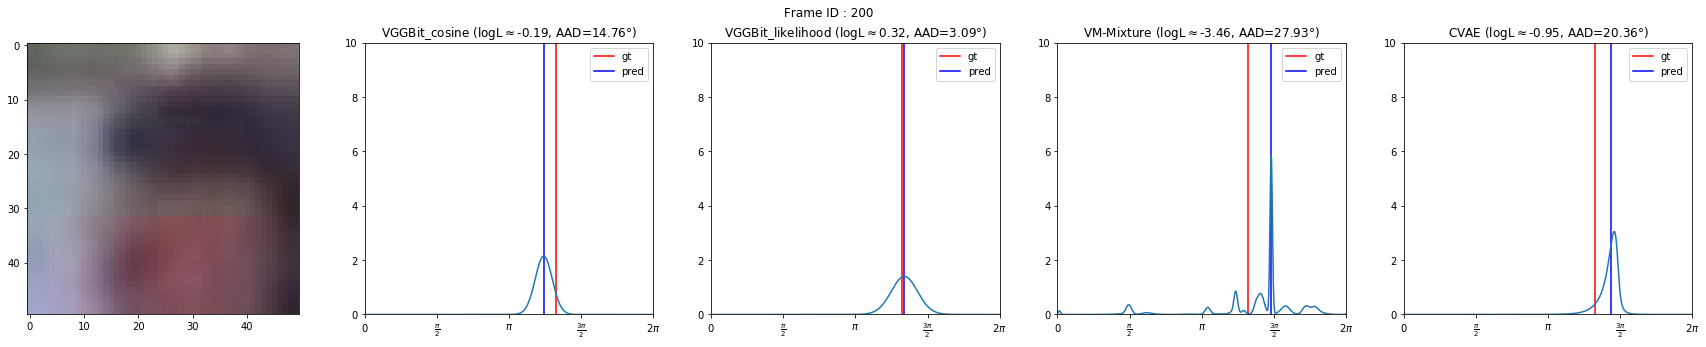

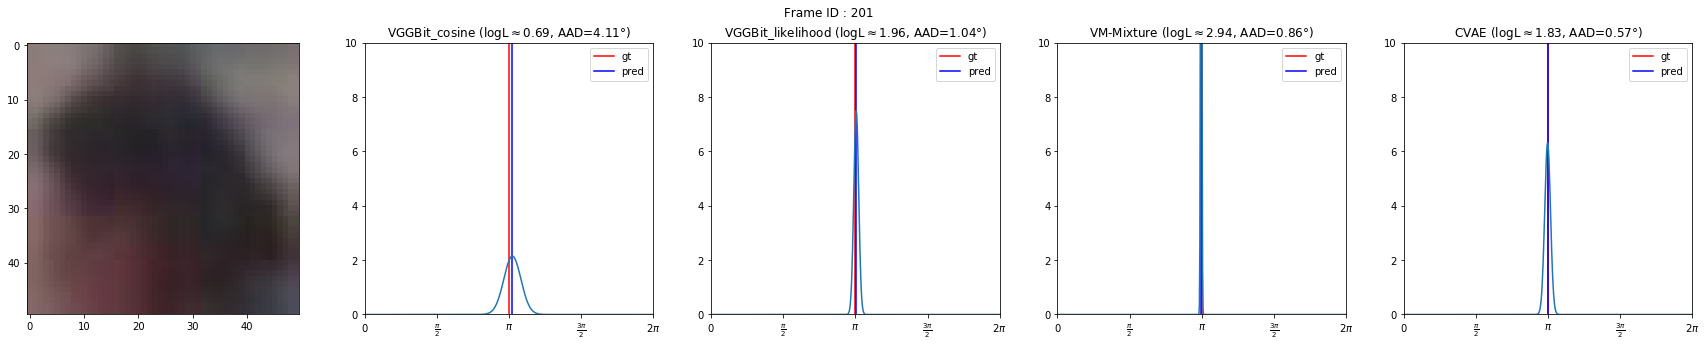

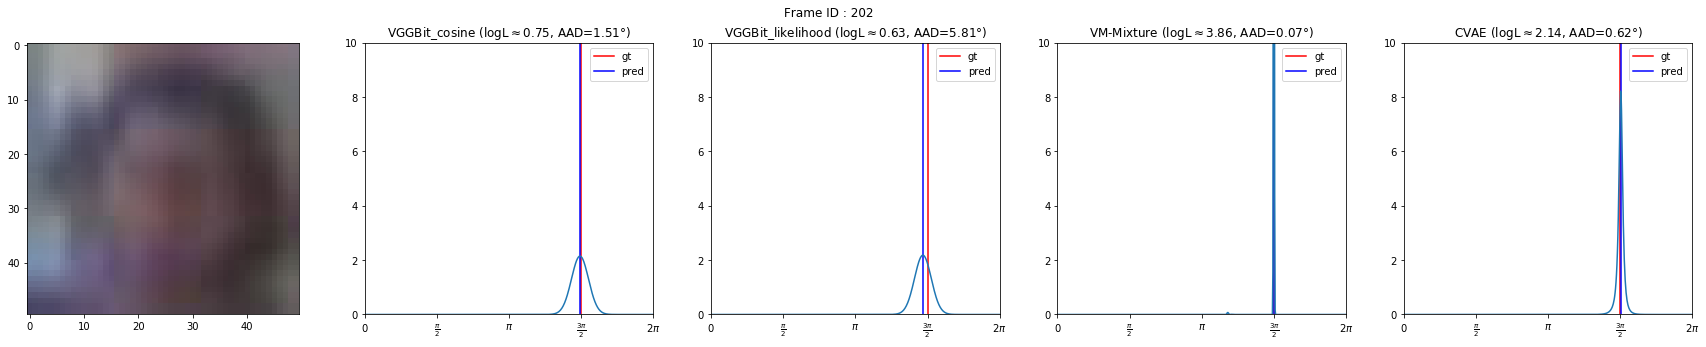

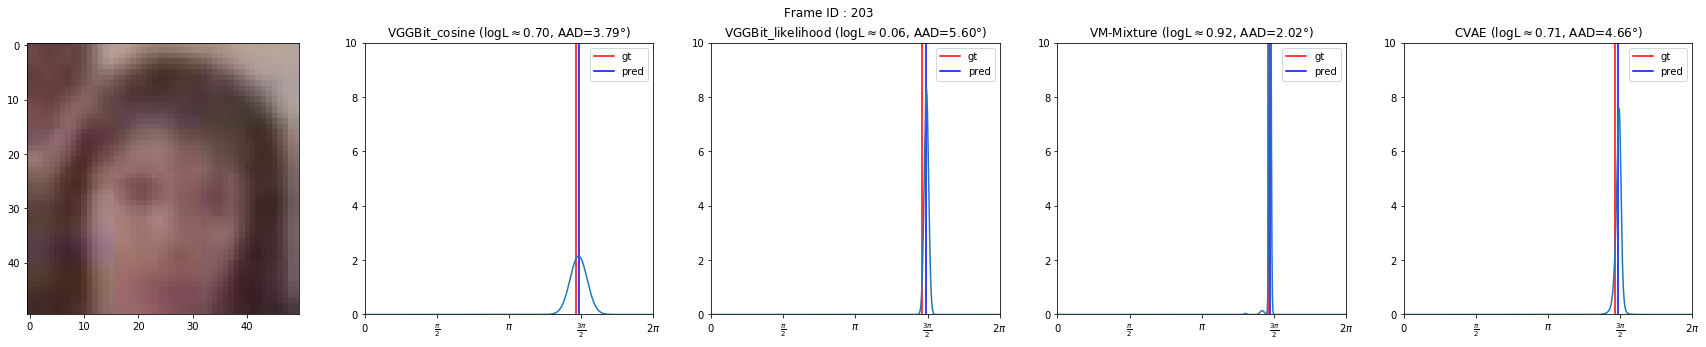

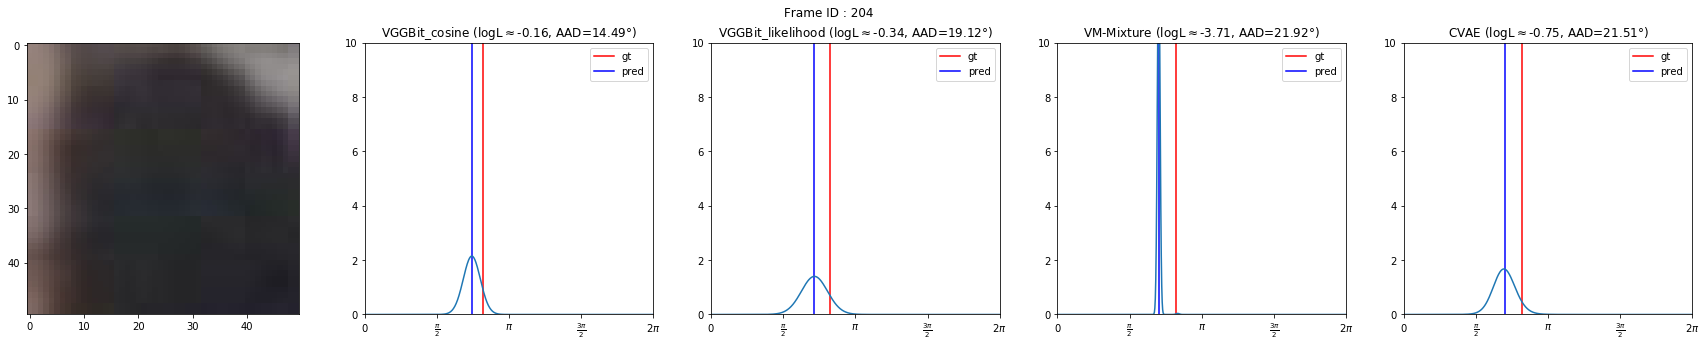

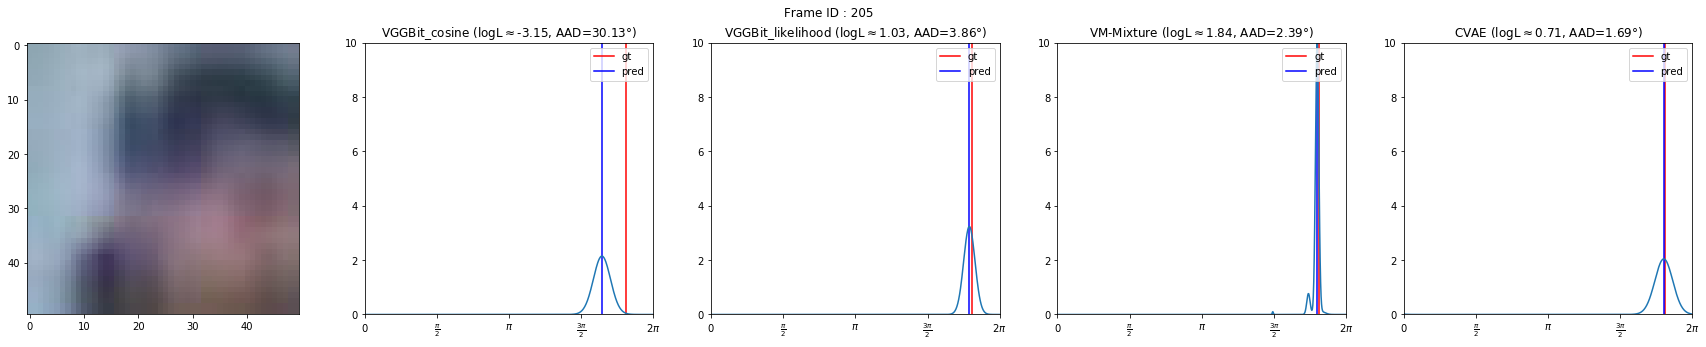

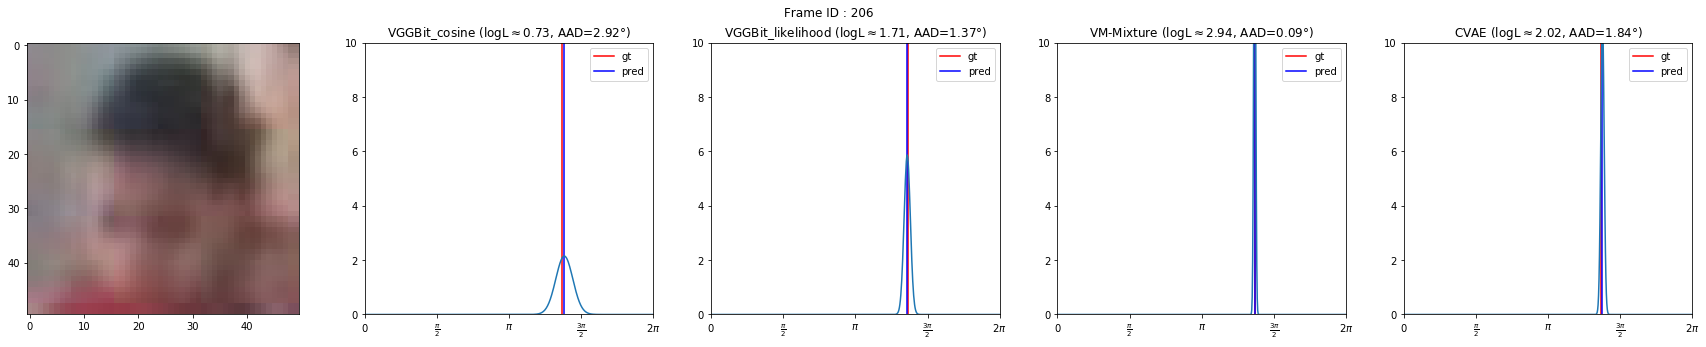

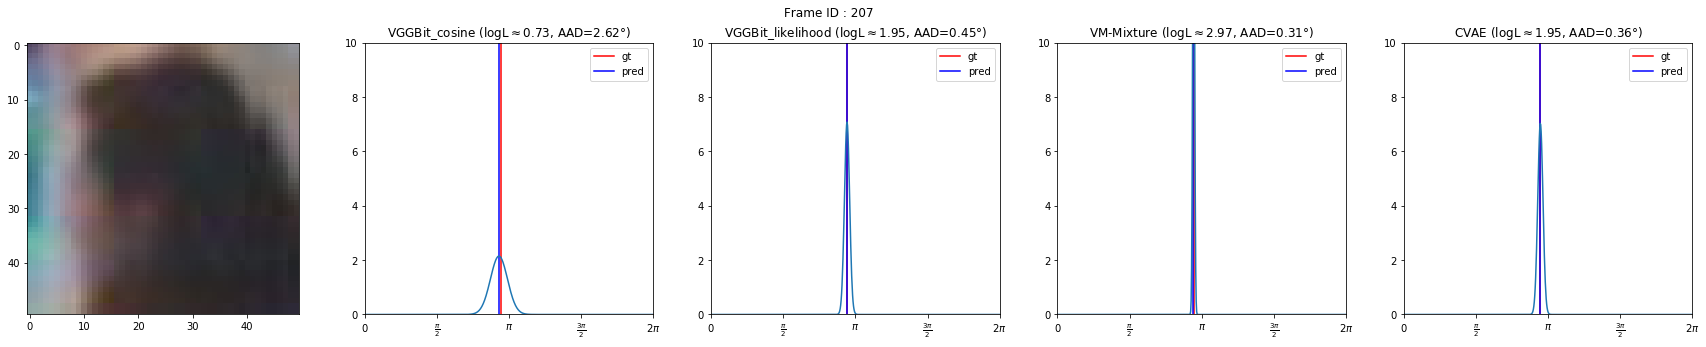

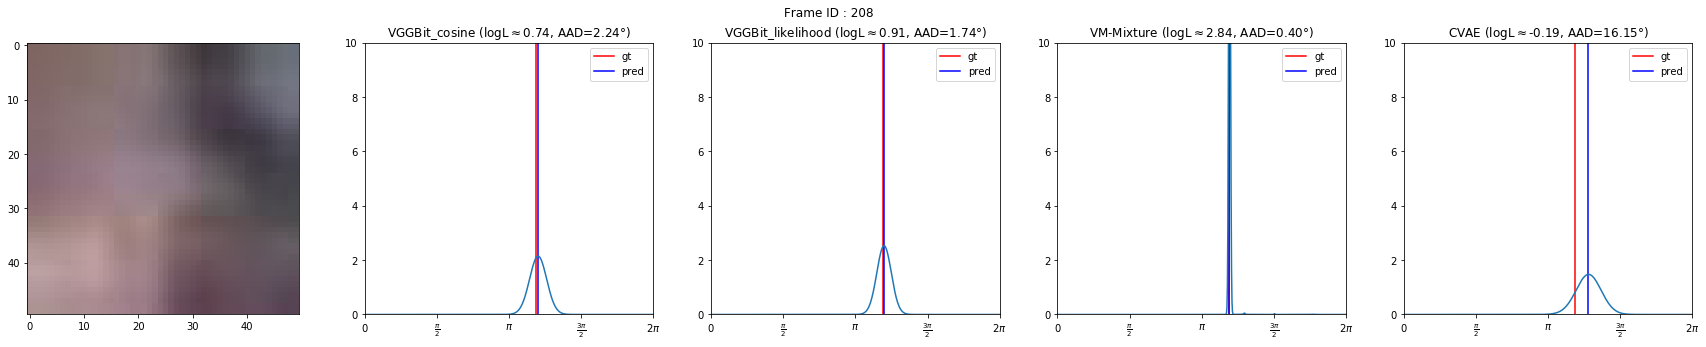

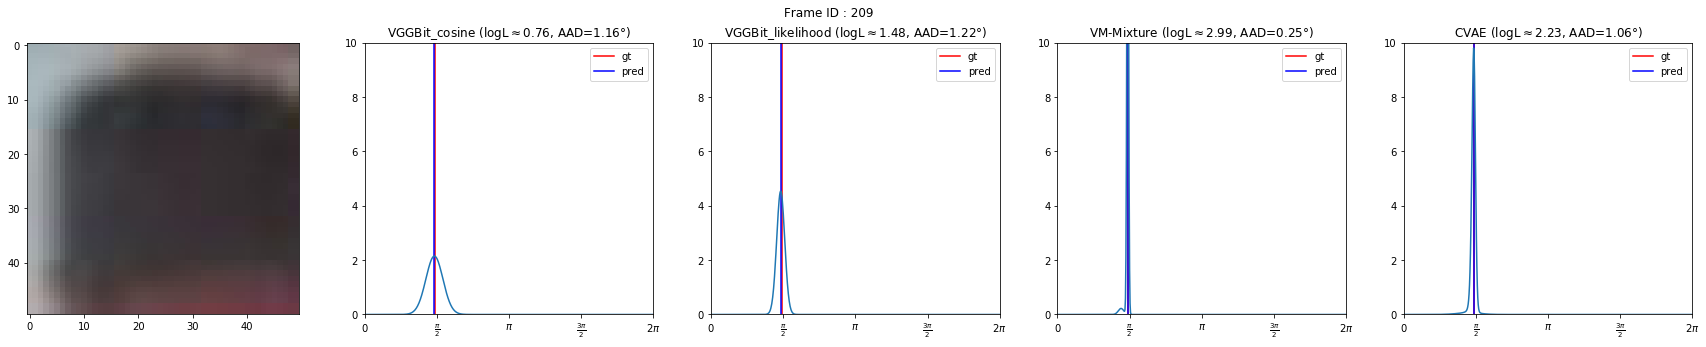

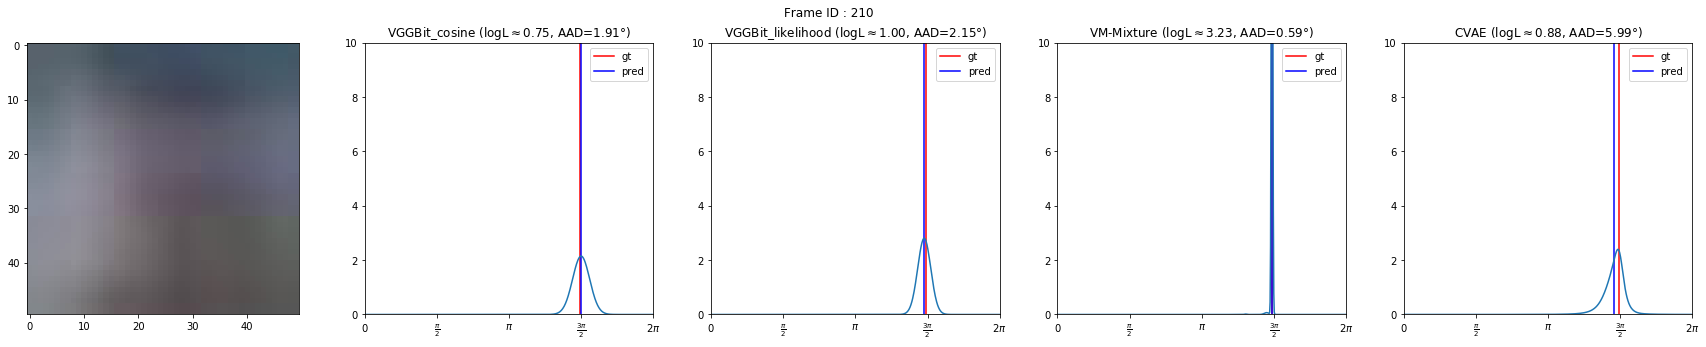

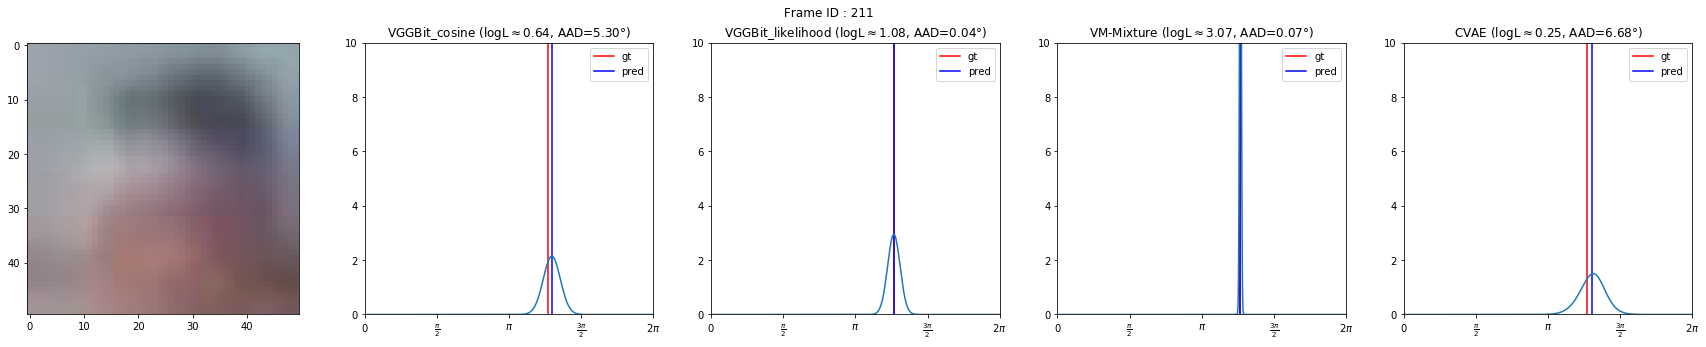

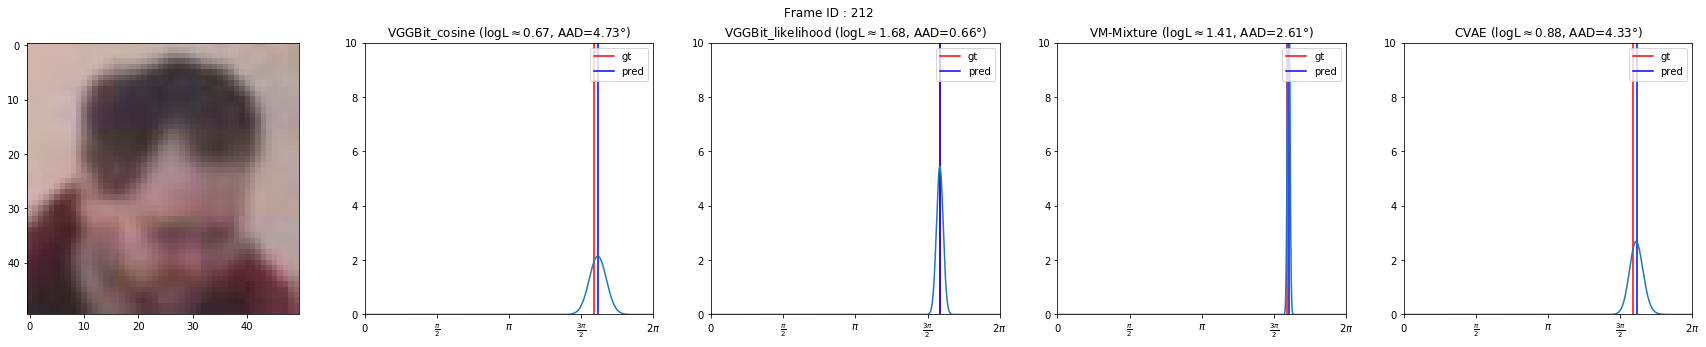

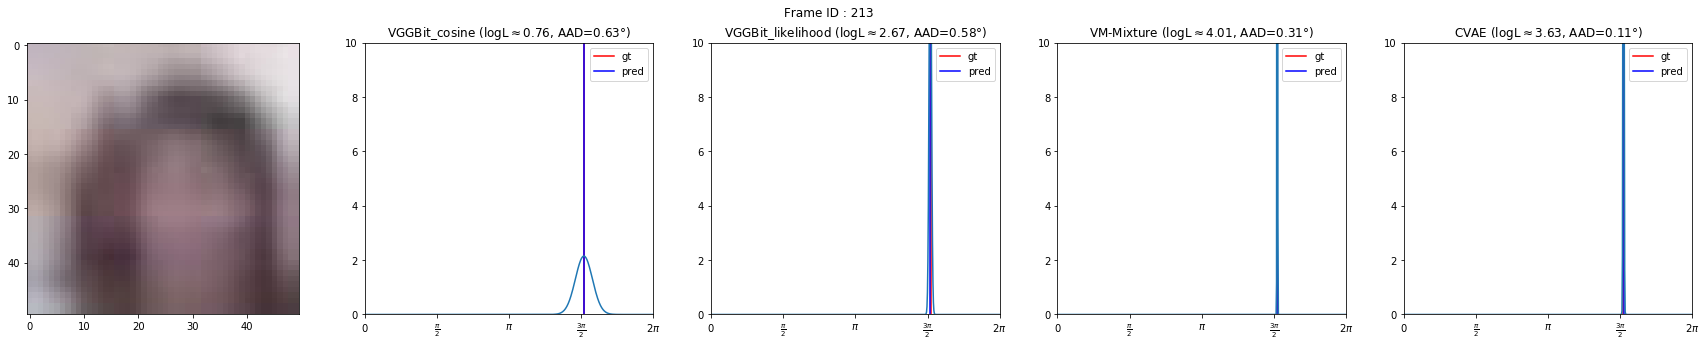

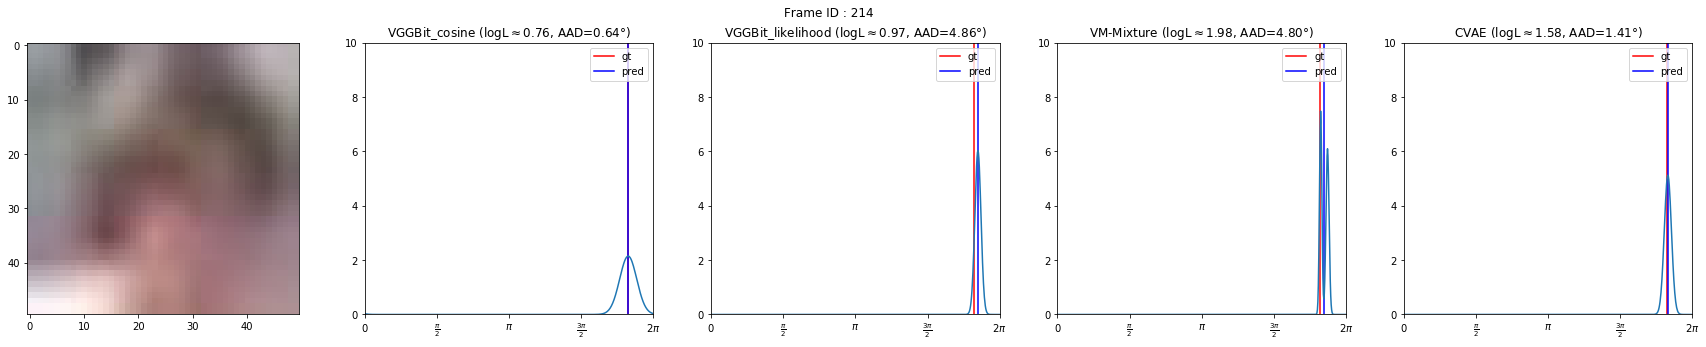

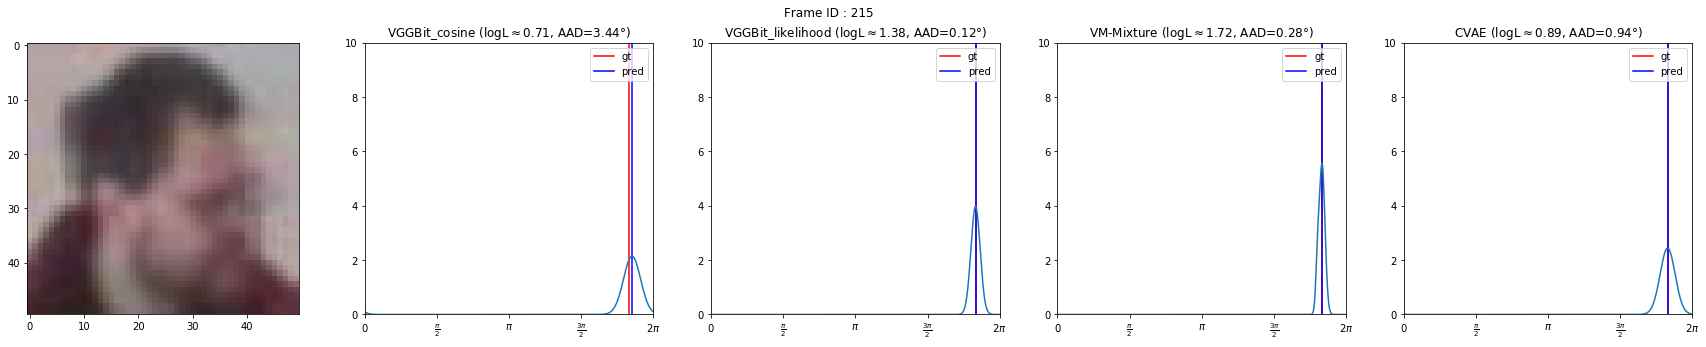

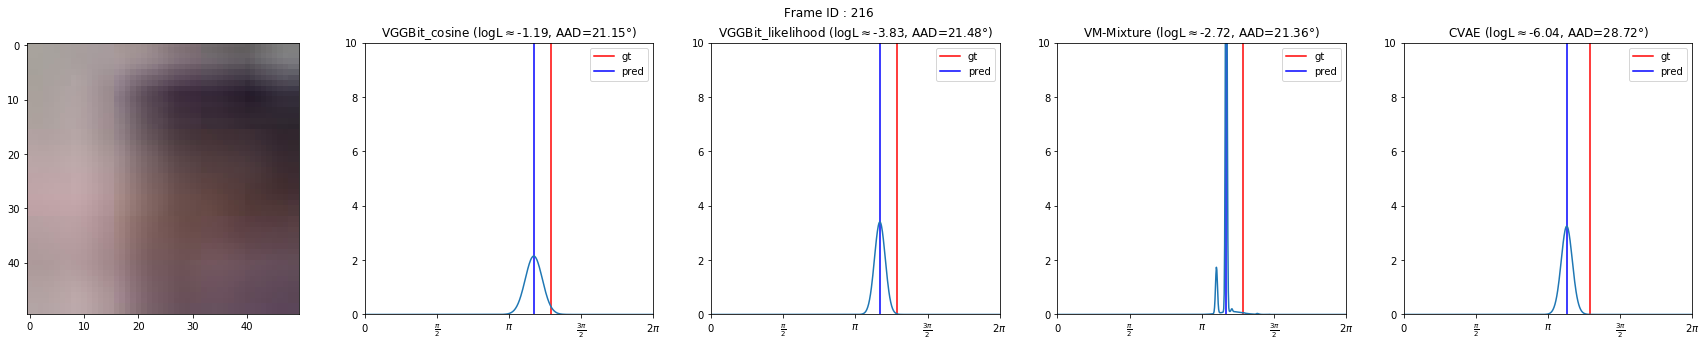

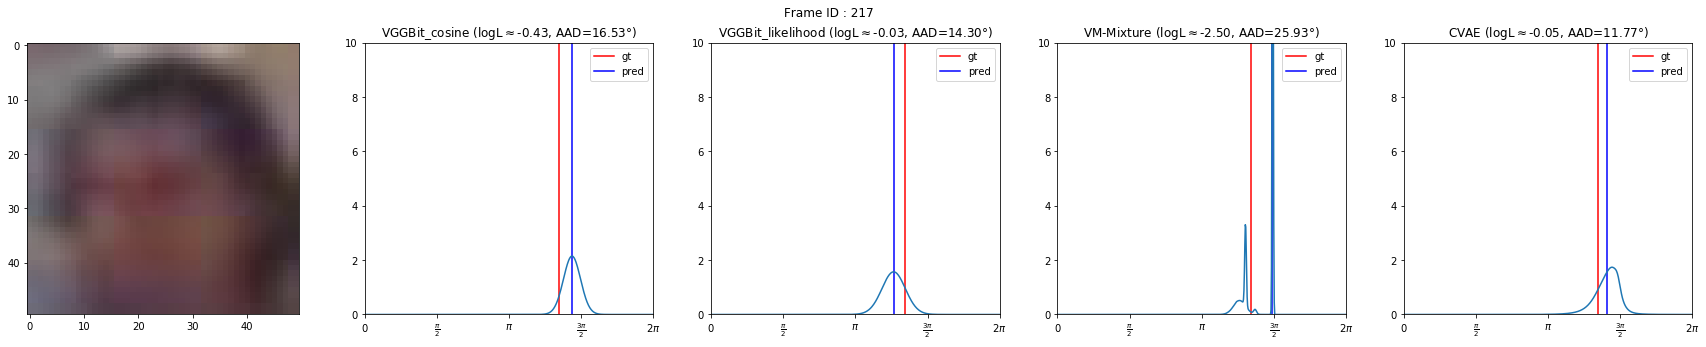

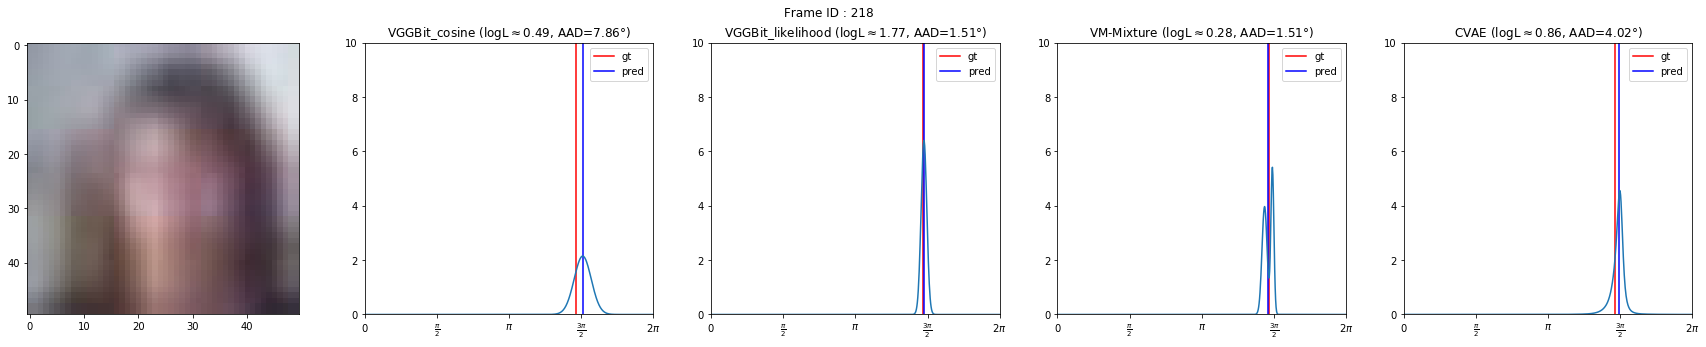

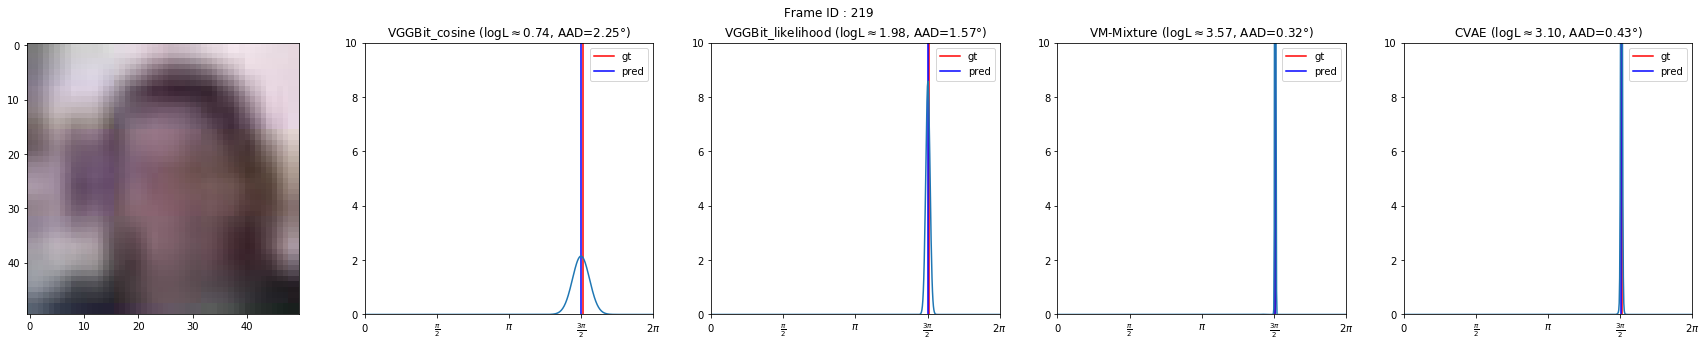

In [691]:
from utils.angles import bit2deg

yte_rad = np.deg2rad(bit2deg(yte_bit))

for fix, fid in enumerate(frames):
    
    pdfs_dict = {}
    likelihoods_dict = {}
    point_preds_dict = {}
    maad_dict = {}
    pdfs_dict['VGGBit_cosine'] = vggcosine_acc_pdf[fix]
    likelihoods_dict['VGGBit_cosine'] = results['cosine']['log_likelihood'][fix]
    maad_dict['VGGBit_cosine'] = results['cosine']['maad'][fix]
    point_preds_dict['VGGBit_cosine'] = results['cosine']['point_preds'][fix]
    pdfs_dict['VGGBit_likelihood'] = vgglikelihood_acc_pdf[fix]
    likelihoods_dict['VGGBit_likelihood'] = results['likelihood']['log_likelihood'][fix]
    maad_dict['VGGBit_likelihood'] = results['likelihood']['maad'][fix]
    point_preds_dict['VGGBit_likelihood'] = results['likelihood']['point_preds'][fix]
    pdfs_dict['VM-Mixture'] = vmmix_acc_pdf[fix]
    likelihoods_dict['VM-Mixture'] = results['mixture']['log_likelihood'][fix]
    maad_dict['VM-Mixture'] = results['mixture']['maad'][fix]
    point_preds_dict['VM-Mixture'] = results['mixture']['point_preds'][fix]
    pdfs_dict['CVAE'] = cvae_acc_pdfs[fix]
    likelihoods_dict['CVAE'] = results['cvae']['importance_log_likelihood'][fix]
    maad_dict['CVAE'] = results['cvae']['maad'][fix]
    point_preds_dict['CVAE'] = results['cvae']['point_preds'][fix]
    #plot_image_results(xte[fid], xvals, cvae_acc_pdfs[fid], cvae_samples_pdfs[fid], yte_rad[fid])
    plot_image_results(xte[fid], fid, xvals,  pdfs_dict, likelihoods_dict, maad_dict, point_preds_dict, yte_rad[fid])

In [553]:
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 

from utils.load_datasets import load_dataset
from models import vgg
from models.cvae import CVAE
from models.vgg_vmmix import BiternionVGGMixture

from models.cvae import CVAE

cvae_model = CVAE(image_height=image_height,
                 image_width=image_width,
                 n_channels=n_channels,
                 **load_config(cvae_config_path))

xvals =  np.arange(0, 2*np.pi, 0.1)
cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[0:10], xvals, n_samples=5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [620]:
np.random.randint(0, len(xte), 10)

array([2619, 1463, 1126, 2048, 1731, 5138, 1793, 2348, 4974, 2390])

/Users/sergey/BiternionNet/py_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


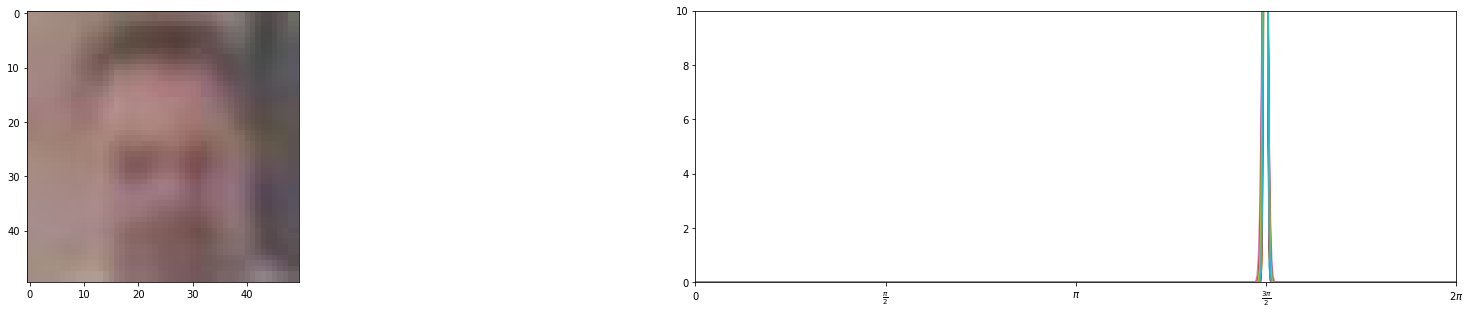

In [715]:
n_samples = 20

demo_frames = np.random.randint(0, len(xte), 10)
x_demo = xte[demo_frames]

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(x_demo, xvals, n_samples=n_samples)

fig, axs = plt.subplots(1, 2, figsize=(30, 5))

fid = np.random.randint(len(x_demo))

axs[0].imshow(x_demo[fid])

for sid in range(0, n_samples):
    plot_pdf(axs[1], xvals, cvae_samples_pdfs[fid, sid,:])

In [922]:
from utils.angles import deg2bit, bit2deg, bit2deg_multi, rad2bit

In [495]:
cvae_model.get_full_output(xte[0:1], yte_bit[0:1])

{'kappa_pred': array([[ 2.51247787]], dtype=float32),
 'log_sigma_encoder': array([[-0.01072216, -0.01361847,  0.01768251,  0.0429116 ,  0.00931163,
          0.02398431,  0.03898891,  0.05656863]], dtype=float32),
 'log_sigma_prior': array([[-0.01279318, -0.03270978,  0.01933658, -0.00773462, -0.03316193,
          0.00305537,  0.00781488, -0.02175405]], dtype=float32),
 'mu_encoder': array([[-0.02576926,  0.01097644, -0.00316324, -0.01133965, -0.04397752,
         -0.00629257, -0.04952348, -0.01184602]], dtype=float32),
 'mu_pred': array([[-0.58822292,  0.80869877]], dtype=float32),
 'mu_prior': array([[ 0.00726331,  0.01550197, -0.04045873, -0.01218999,  0.01696199,
         -0.00069345, -0.00238084,  0.00930805]], dtype=float32),
 'u_encoder_samples': array([[-1.48734963, -1.58485746, -0.3104831 ,  0.79476798,  0.40982544,
          1.35674846, -0.17275383, -0.24918564]], dtype=float32)}

In [222]:
from utils.angles import bit2deg

bit2deg(cvae_model.get_full_output(xte[0:1], yte_bit[0:1])['mu_pred'])

array([ 83.60684204], dtype=float32)

In [156]:
cvae_model.get_full_output(xte[0:1], yte_bit[2:1])['kappa_pred']

IndexError: index 0 is out of bounds for axis 0 with size 0

In [163]:
cvae_model.get_full_output(xte[0:1], yte_bit[0:1])['u_encoder_samples']

array([[ 1.50650573,  0.30695483,  0.75444806,  1.11070549, -0.01840132,
        -0.78256691, -0.75187391,  1.95079756]], dtype=float32)

In [1182]:
cvae_model.get_full_output(xte[0:1], yte_bit[0:1])['u_encoder_samples']

array([[ 0.98596197,  0.11848653,  0.79178113, -0.79030037, -0.28618744,
         1.02045012,  0.70742929,  0.24045542]], dtype=float32)

In [975]:
cvae_model.decoder_model.predict(xte[1:2])[:,2]

array([ 1.04503703], dtype=float32)

In [309]:
results['likelihood']['log_likelihood'].shape

(100, 1)